<a href="https://colab.research.google.com/github/zolo012/Machine_learning/blob/main/Decisiontree_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision tree and Random forest

Creator: Bereczki Zoltán

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay


In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 23.2 MB 115 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# I. Prepare dataset
- Load the in-vehicle-coupon-recommendation.csv dataset
- Search for missing values and if needed, handle them!
- Encode the non numeric variables into numeric ones! For the binary features simply encode them as ($0$/$1$). Do not create two separate columns for them! You'll have to use the description of the dataset provided at its download location!

In [ ]:
uploaded = files.upload()

Saving in-vehicle-coupon-recommendation.csv to in-vehicle-coupon-recommendation (1).csv


In [ ]:
vehicle_cp_df = pd.read_csv(io.BytesIO(uploaded['in-vehicle-coupon-recommendation.csv']))
vehicle_cp_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,1,1,0,1,0


In [ ]:
vehicle_cp_df.isna().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

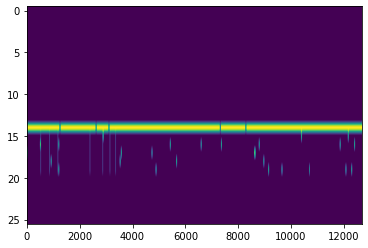

In [ ]:
plt.imshow(vehicle_cp_df.isna().T, aspect='auto') 

In [ ]:
# Remove 'car' column
vehicle_cp_df.drop('car', axis=1, inplace=True)

In [ ]:
# Remove rows that contain any missing values
vehicle_cp_df.dropna(inplace=True)

# Reindex because of removed rows
vehicle_cp_df.reset_index(inplace=True)

# Save original indices
orig_indices = vehicle_cp_df.pop('index')

In [ ]:
vehicle_cp_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,never,less1,4~8,4~8,less1,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,never,less1,4~8,4~8,less1,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,never,less1,4~8,4~8,less1,1,0,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,never,less1,4~8,4~8,less1,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,0,Bachelors degree,Architecture & Engineering,$62500 - $74999,never,less1,4~8,4~8,less1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3,1,0,0,1,0,1
12075,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3,1,0,0,0,1,1
12076,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3,1,0,0,1,0,0
12077,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,never,never,1~3,4~8,1~3,1,1,1,0,1,0


In [ ]:
vehicle_cp_df.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [ ]:
vehicle_cp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12079 non-null  object
 1   passanger             12079 non-null  object
 2   weather               12079 non-null  object
 3   temperature           12079 non-null  int64 
 4   time                  12079 non-null  object
 5   coupon                12079 non-null  object
 6   expiration            12079 non-null  object
 7   gender                12079 non-null  object
 8   age                   12079 non-null  object
 9   maritalStatus         12079 non-null  object
 10  has_children          12079 non-null  int64 
 11  education             12079 non-null  object
 12  occupation            12079 non-null  object
 13  income                12079 non-null  object
 14  Bar                   12079 non-null  object
 15  CoffeeHouse           12079 non-null

In [ ]:
code_dict = {}

col_names = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
for col_name in col_names:
  code_dict.update({col_name : {'originate' : [], 'code' :[]}})
  for code, orig in enumerate(vehicle_cp_df[col_name].unique()):
    vehicle_cp_df[col_name].replace(orig, code, inplace=True)
    code_dict[col_name]['originate'].append(orig)
    code_dict[col_name]['code'].append(code)




for col_name, values in code_dict.items():
  print(col_name, '\t{}'.format(values))




destination 	{'originate': ['No Urgent Place', 'Home', 'Work'], 'code': [0, 1, 2]}
passanger 	{'originate': ['Alone', 'Friend(s)', 'Kid(s)', 'Partner'], 'code': [0, 1, 2, 3]}
weather 	{'originate': ['Sunny', 'Rainy', 'Snowy'], 'code': [0, 1, 2]}
time 	{'originate': ['2PM', '10AM', '6PM', '7AM', '10PM'], 'code': [0, 1, 2, 3, 4]}
coupon 	{'originate': ['Restaurant(<20)', 'Coffee House', 'Bar', 'Carry out & Take away', 'Restaurant(20-50)'], 'code': [0, 1, 2, 3, 4]}
expiration 	{'originate': ['1d', '2h'], 'code': [0, 1]}
gender 	{'originate': ['Male', 'Female'], 'code': [0, 1]}
age 	{'originate': ['21', '46', '26', '31', '41', '50plus', '36', 'below21'], 'code': [0, 1, 2, 3, 4, 5, 6, 7]}
maritalStatus 	{'originate': ['Single', 'Married partner', 'Unmarried partner', 'Divorced', 'Widowed'], 'code': [0, 1, 2, 3, 4]}
education 	{'originate': ['Bachelors degree', 'Some college - no degree', 'Associates degree', 'High School Graduate', 'Graduate degree (Masters or Doctorate)', 'Some High School

In [ ]:
# Convert the encoded columns into categorical type

vehicle_cp_df[col_names] = vehicle_cp_df[col_names].astype('category')

In [ ]:
vehicle_cp_df.dtypes

destination             category
passanger               category
weather                 category
temperature                int64
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [ ]:
vehicle_cp_df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
1,0,1,0,80,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,1,0,80,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
3,0,1,0,80,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
4,0,1,0,80,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,1,3,1,55,2,3,0,0,2,0,0,0,6,2,0,4,1,0,2,1,0,0,1,0,1
12075,2,0,1,55,3,3,0,0,2,0,0,0,6,2,0,4,1,0,2,1,0,0,0,1,1
12076,2,0,2,30,3,1,0,0,2,0,0,0,6,2,0,4,1,0,2,1,0,0,1,0,0
12077,2,0,2,30,3,2,0,0,2,0,0,0,6,2,0,4,1,0,2,1,1,1,0,1,0



# II. Train & visualize decision tree classifier
- Train a decision tree classifier using the sklearn API
  - Use its default parameters
  - Use all the data
- Visualize the decision tree, with the Gini impurities also showing on the plot. The plot_tree function in sklearn will be really helpful. You may or may not need to tune its arguments to get a reasonable result.
- Manually check for the labels and for an arbitrary feature whether the returned Gini impurities are correct
- In a few sentences, discuss the results

In [ ]:
# Split data into features (X) and target (y)
y = vehicle_cp_df.pop('Y')
X = vehicle_cp_df


In [ ]:
# Create decisiontreeclassifier object
decisiontreeclassifier = DecisionTreeClassifier(max_depth=4)

# Train it with all data
decisiontreeclassifier.fit(X, y)

#y_pred2 = decisiontreeclassifier.predict(X)
#print("Accuracy:", accuracy_score(y, y_pred2))

DecisionTreeClassifier(max_depth=4)

[Text(5580.0, 2446.2, 'coupon <= 0.5\ngini = 0.49\nsamples = 12079\nvalue = [5202, 6877]\nclass = 1'),
 Text(2790.0, 1902.6, 'toCoupon_GEQ25min <= 0.5\ngini = 0.413\nsamples = 2653\nvalue = [772, 1881]\nclass = 1'),
 Text(1395.0, 1359.0, 'expiration <= 0.5\ngini = 0.368\nsamples = 2358\nvalue = [574, 1784]\nclass = 1'),
 Text(697.5, 815.3999999999999, 'time <= 2.5\ngini = 0.274\nsamples = 1260\nvalue = [206, 1054]\nclass = 1'),
 Text(348.75, 271.7999999999997, 'gini = 0.211\nsamples = 800\nvalue = [96, 704]\nclass = 1'),
 Text(1046.25, 271.7999999999997, 'gini = 0.364\nsamples = 460\nvalue = [110, 350]\nclass = 1'),
 Text(2092.5, 815.3999999999999, 'time <= 2.5\ngini = 0.446\nsamples = 1098\nvalue = [368, 730]\nclass = 1'),
 Text(1743.75, 271.7999999999997, 'gini = 0.398\nsamples = 835\nvalue = [229, 606]\nclass = 1'),
 Text(2441.25, 271.7999999999997, 'gini = 0.498\nsamples = 263\nvalue = [139, 124]\nclass = 0'),
 Text(4185.0, 1359.0, 'time <= 2.5\ngini = 0.441\nsamples = 295\nvalue =

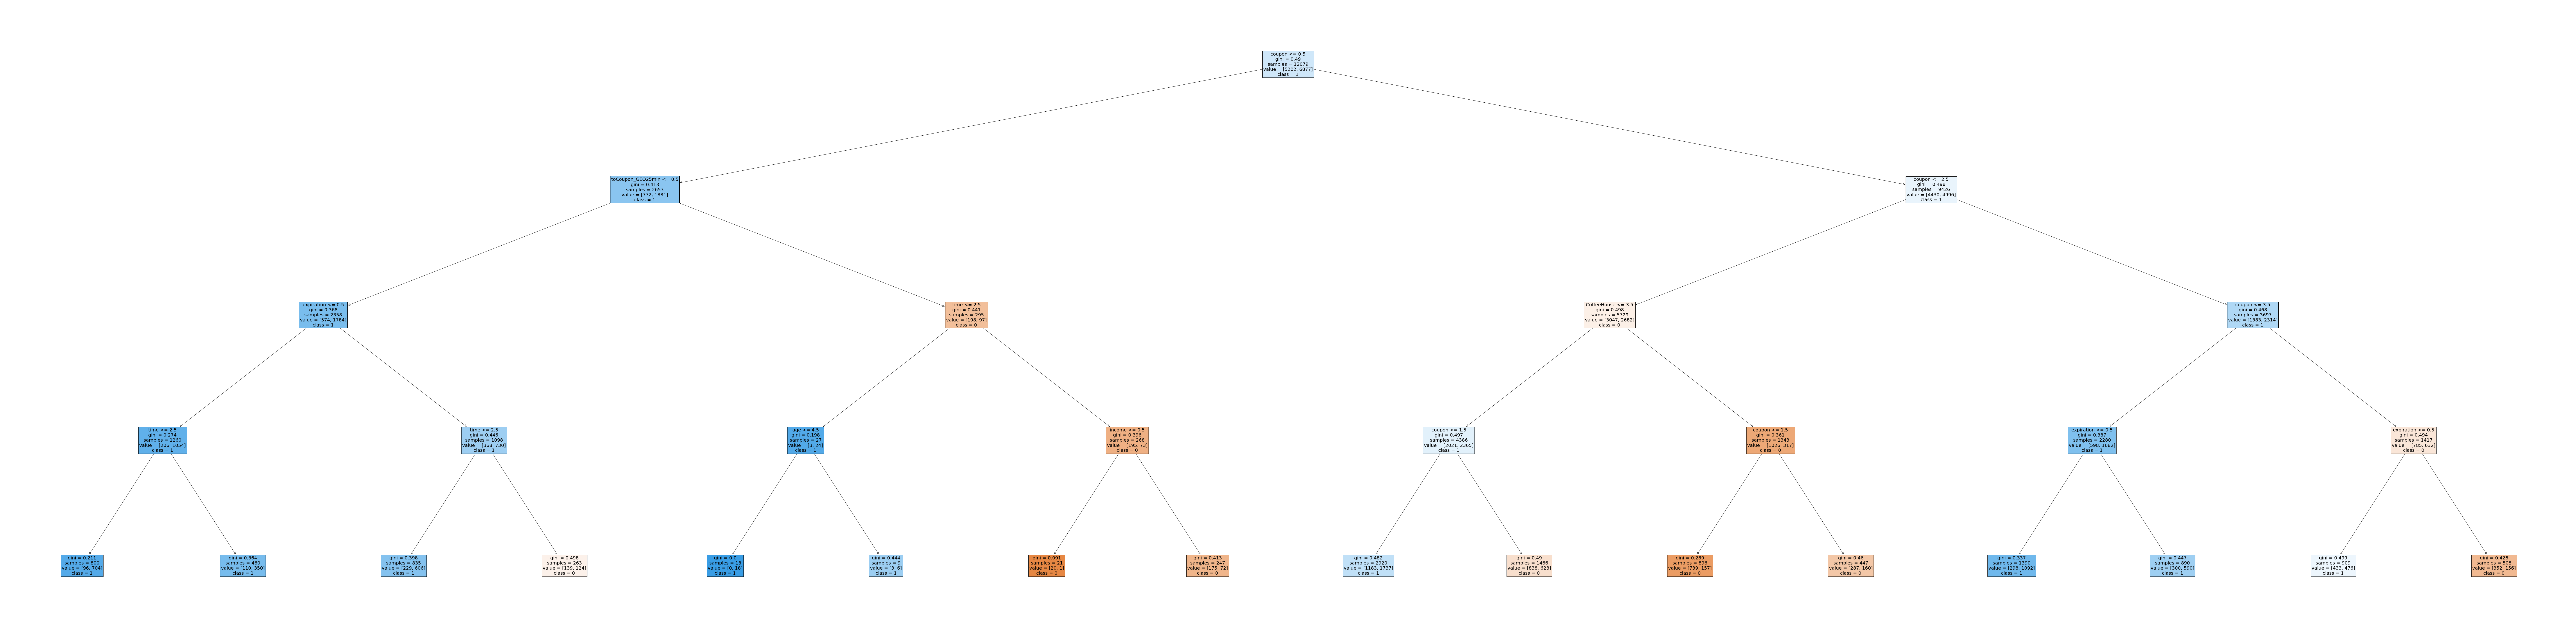

In [ ]:
 # Visualize decision tree with Gini impurities
plt.figure(figsize=(200, 50))
#plt.figure(figsize=(20, 50))
plot_tree(decisiontreeclassifier, feature_names=X.columns, filled=True, class_names=['0', '1'], fontsize=20)

In [ ]:
# 0 y class
print('0 y class: ', vehicle_cp_df[y == 0].shape[0])

# 1 y class
print('1 class: ', vehicle_cp_df[y==1].shape[0])

# 0 y class + coupon <= 0.5
print('\n0 y class + coupon <= 0.5: ', vehicle_cp_df[y==0][vehicle_cp_df.coupon == 0].shape[0])

# 1 y class + coupon <= 0.5
print('1 y class + coupon <= 0.5: ', vehicle_cp_df[y==1][vehicle_cp_df.coupon == 0].shape[0])


0 y class:  5202
1 class:  6877

0 y class + coupon <= 0.5:  772
1 y class + coupon <= 0.5:  1881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Gini impurity of to toCouponGEQ25min

no_GEQ25min = vehicle_cp_df[y==0][vehicle_cp_df.coupon == 0][vehicle_cp_df.toCoupon_GEQ25min == 0].shape[0]
print('y 0 + coupon 0 + toCouponGEQ25min 0: {}'.format(no_GEQ25min))

yes_GEQ25min = vehicle_cp_df[y==1][vehicle_cp_df.coupon == 0][vehicle_cp_df.toCoupon_GEQ25min == 0].shape[0]
print('y 1 + coupon 0 + toCouponGEQ25min 0: {}'.format(yes_GEQ25min))

# Sum of them (GEQ25min <= 0.5)
sum = no_GEQ25min + yes_GEQ25min

# Gini impurity = 1 - probability of GEQ25min <= 0.5 in class 0 on the power of 2 - probability of GEQ25min <= 0.5 in class 2 on the power of 2
gini = 1 - (no_GEQ25min/sum)**2 - (yes_GEQ25min/sum)**2

print('\nGini impurity of expiration <= 0.5 named node: {}'.format(gini))


y 0 + coupon 0 + toCouponGEQ25min 0: 574
y 1 + coupon 0 + toCouponGEQ25min 0: 1784

Gini impurity of expiration <= 0.5 named node: 0.3683402144253298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# III. Random forest feature importance
- Train a random forest classifier on all the data using the sklearn API
  - Use default values again, but fix the random_state to $57$!
- Plot the importance values of the $10$ most important features
  - Create a bar plot where the height of the bar is the feature importance
  - The feature_importances_ attribute is helpful

In [ ]:
# Create RandomForestClassifier object
rfclf = RandomForestClassifier(random_state=57)

# Fit it to data
rfclf.fit(X, y)

RandomForestClassifier(random_state=57)

In [ ]:
# Find the first 10 important features based on RandomForestClassifier
feature_imp_df = pd.Series(data=rfclf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp_df[:10]

coupon                  0.109572
occupation              0.088386
income                  0.077653
CoffeeHouse             0.066945
age                     0.064688
time                    0.058167
education               0.052129
Bar                     0.049027
CarryAway               0.047440
RestaurantLessThan20    0.046965
dtype: float64

In [ ]:
feature_imp_df[:10].index

Index(['coupon', 'occupation', 'income', 'CoffeeHouse', 'age', 'time',
       'education', 'Bar', 'CarryAway', 'RestaurantLessThan20'],
      dtype='object')

Text(0.5, 1.0, 'First 10 important features')

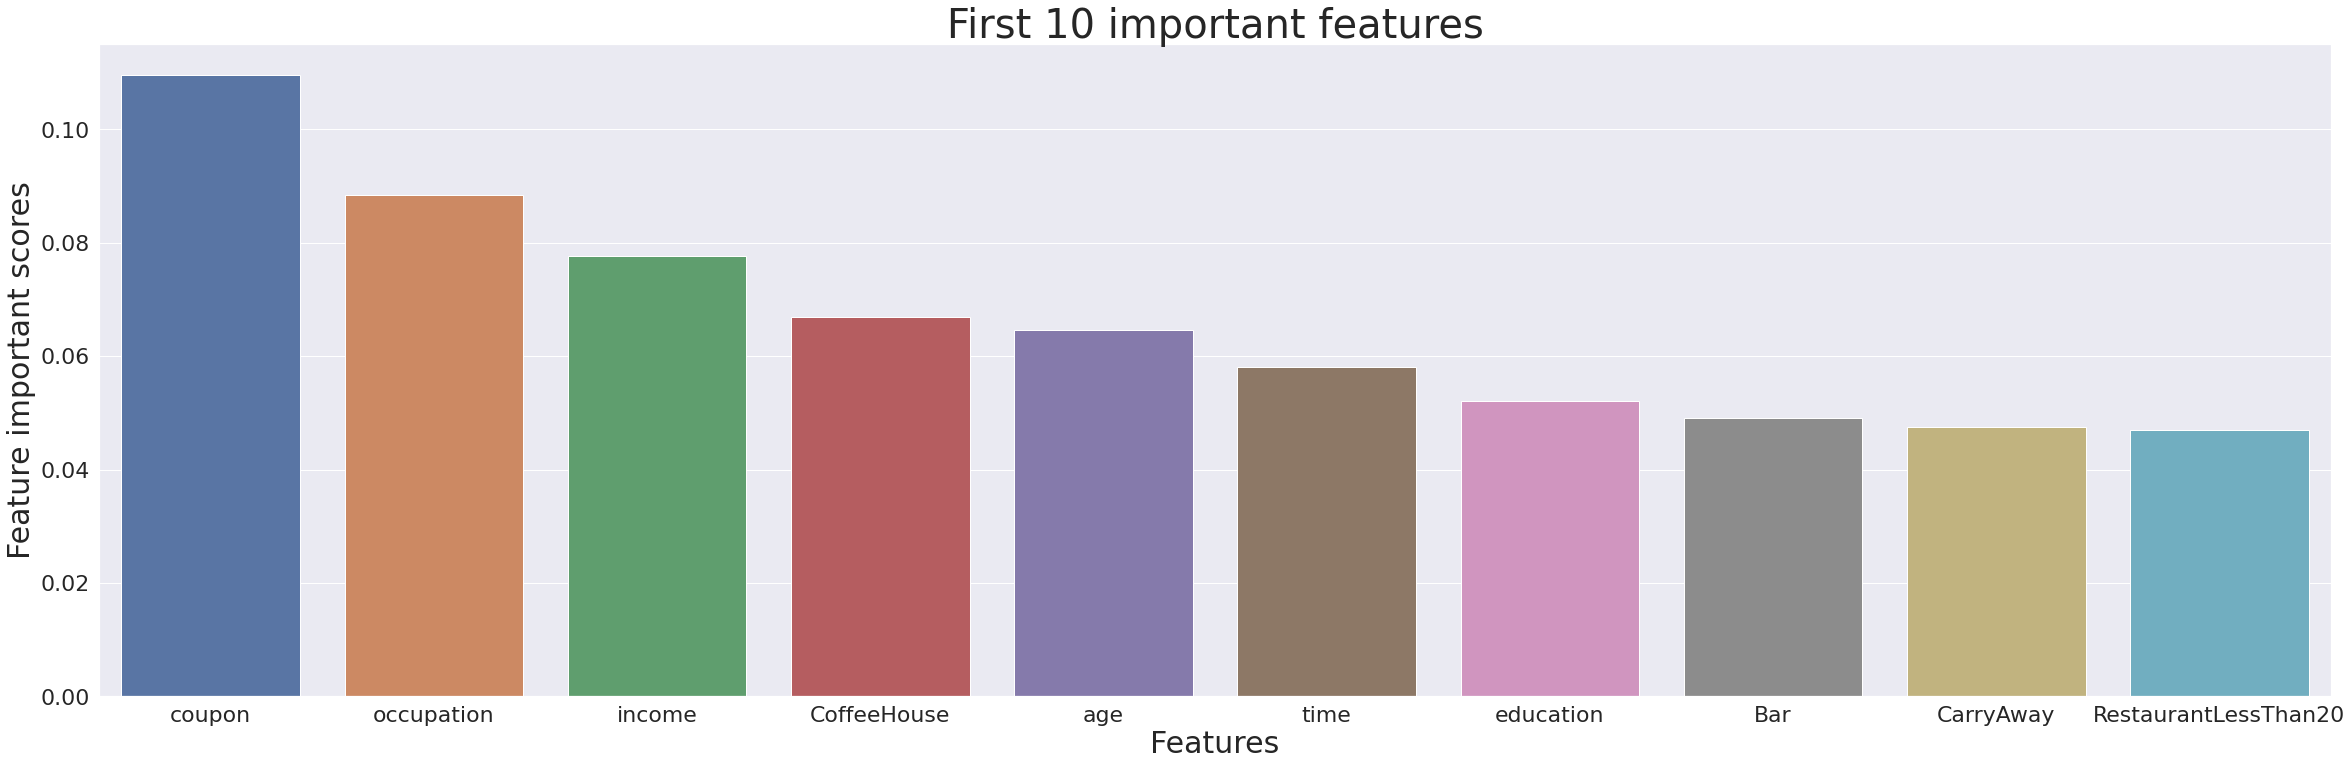

In [ ]:
plt.figure(figsize=(40, 12))
sns.set(font_scale=2)
sns.barplot(x=feature_imp_df[:10].index, y=feature_imp_df[:10])
plt.xlabel('Features', fontsize=30)
plt.ylabel('Feature important scores', fontsize=30)
plt.title('First 10 important features', fontsize=40)




# IV. Evaluation
- Generate prediction probabilities with a decision tree and with a random forest model
  - Use $5$-fold cross validation for both models
  - Use default parameters for both models
-Compare the two models with ROC curves
  - Why does the shape of the decision tree's ROC curve looks different?

In [ ]:
# 5-fold cross validation
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
cv.get_n_splits(X, y)

5

Train: [    0     1     2 ... 12075 12077 12078] 	Test: [    5     6    12 ... 12066 12074 12076]
Train: [    0     1     2 ... 12076 12077 12078] 	Test: [   13    14    15 ... 12056 12068 12070]
Train: [    0     2     4 ... 12076 12077 12078] 	Test: [    1     3     7 ... 12067 12069 12072]
Train: [    0     1     3 ... 12076 12077 12078] 	Test: [    2     8     9 ... 12061 12071 12075]
Train: [    1     2     3 ... 12074 12075 12076] 	Test: [    0     4    11 ... 12073 12077 12078]


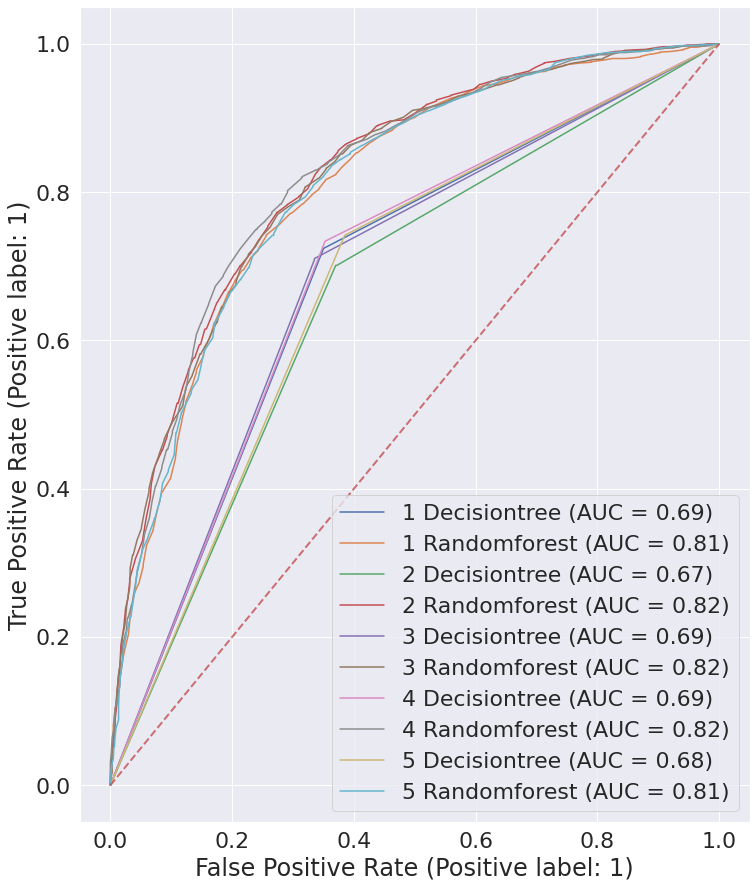

In [ ]:
# Prepare models
dtclf = DecisionTreeClassifier()
rfclf = RandomForestClassifier()

# Create figure
fig, ax = plt.subplots(figsize=(12, 15))

# Apply cross validation
for id, (train_i, test_i) in enumerate(cv.split(X, y)):
  print('Train: {}'.format(train_i), '\tTest: {}'.format(test_i))
  X_train, X_test = X.iloc[train_i, :], X.iloc[test_i, :]
  y_train, y_test = y[train_i], y[test_i]

  # Fit the models 
  dtclf.fit(X_train, y_train)
  rfclf.fit(X_train, y_train)

  # Predict with models
  y_pred_dtclf = dtclf.predict_proba(X_test)
  y_pred_rfclf = rfclf.predict_proba(X_test)
  
  # Display ROC curves
  RocCurveDisplay.from_predictions(y_test, y_pred_dtclf[:, 1], ax=ax, name='{} Decisiontree'.format(id +1))
  RocCurveDisplay.from_predictions(y_test, y_pred_rfclf[:, 1], ax=ax, name='{} Randomforest'.format(id +1))
  ax.set_xlabel


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)

The ROC curve shapes are different, because the radomforest uses many tree to make them vote before assigning a final decision despite decision tree, it uses only one tree to make its final decision. 

# V. Tuning model
- Using $80\%$ - $20\%$ train-test split generate predictions for a random forest model
  - Set the random_state parameter for every run to $57$ for the train-test split and for the Random Forest Classifier as well!
- Plot the AUC as the function of the number of trees in the forest for both the traing and the test data!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=57)
print('X train: {}\tX test: {}'.format(X_train.shape[0], X_test.shape[0]))
print('y train: {}\ty test: {}'.format(y_train.shape[0], y_test.shape[0]))

X train: 9663	X test: 2416
y train: 9663	y test: 2416


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has featu

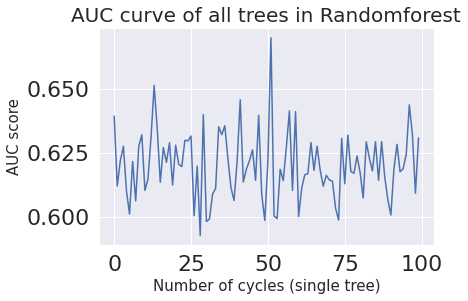

In [ ]:
# Create RandomForestClassifier object
rfclf = RandomForestClassifier(random_state=57)

# Fit it to training data
rfclf.fit(X_train, y_train)

aucs_list = [roc_auc_score(tree.predict(X_test) , y_test) for tree in rfclf.estimators_]

# Plot auc
plt.figure()
plt.title('AUC curve of all trees in Randomforest', fontsize=20)
plt.xlabel('Number of cycles (single tree)', fontsize=15)
plt.ylabel('AUC score', fontsize=15)
plt.plot(range(len(rfclf.estimators_)), aucs_list)





Tree number: 100
Tree number: 900
Tree number: 1700
Tree number: 2500
Tree number: 3300
Tree number: 4100
Tree number: 4900
Tree number: 5700
Tree number: 6500
Tree number: 7300
Tree number: 8100
Tree number: 8900
Tree number: 9700


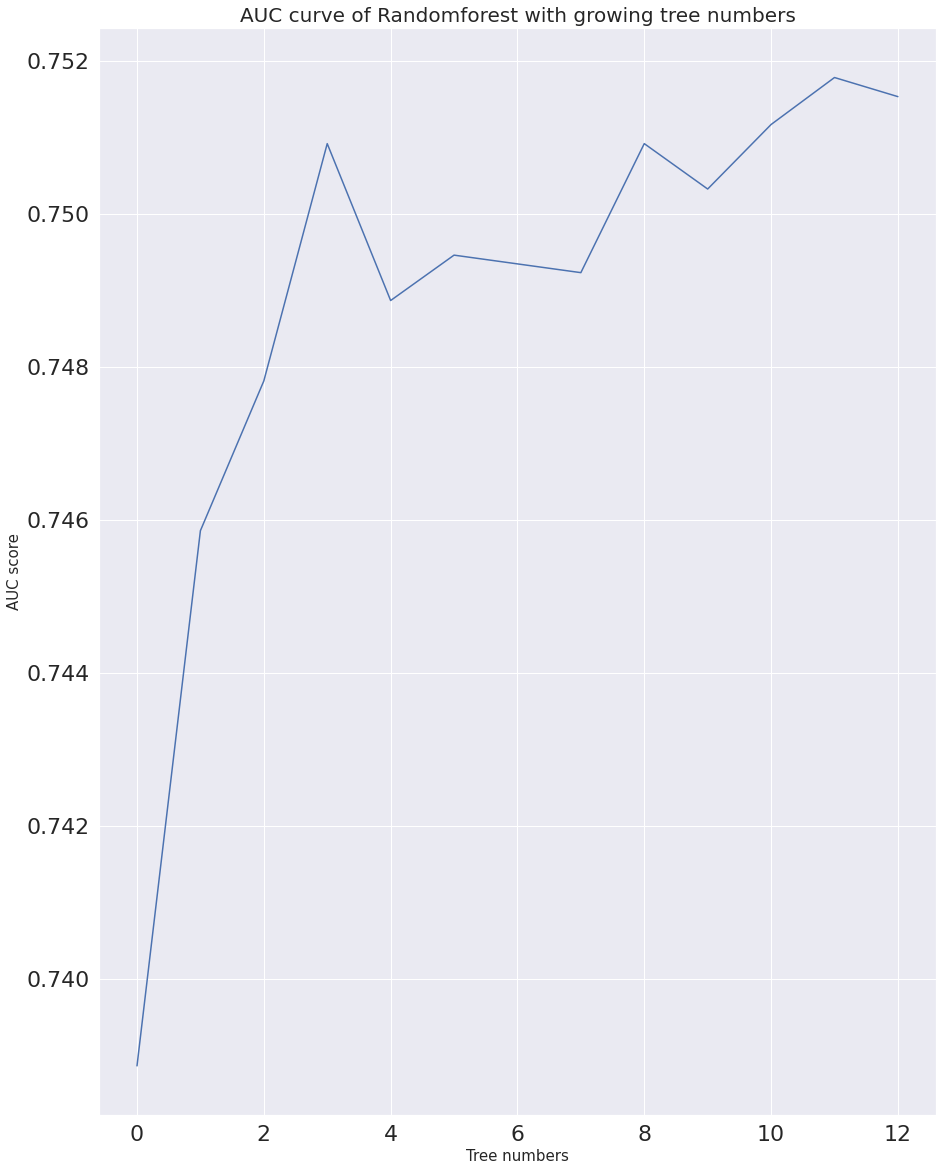

In [ ]:
auc_scores_list = []


# Create RandomForestClassifier object with increasing number of trees
for tree_numb in range(100, 10000, 800):
  print('Tree number: {}'.format(tree_numb))
  rfclf = RandomForestClassifier(n_estimators=tree_numb, random_state=57)
  # Fit it to training data
  rfclf.fit(X_train, y_train)
  
  # Predict y from test set
  y_pred = rfclf.predict(X_test)

  # Add auc score to the list
  auc_scores_list.append(roc_auc_score(y_test, y_pred))



# Plot auc
plt.figure(figsize=(15, 20))
plt.title('AUC curve of Randomforest with growing tree numbers', fontsize=20)
plt.xlabel('Tree numbers', fontsize=15)
plt.ylabel('AUC score', fontsize=15)
plt.plot(range(len(auc_scores_list)), auc_scores_list)
